In [1]:
from pathlib import Path

import torch
import numpy as np
import random
import pickle
from absl import logging
from absl.flags import FLAGS
from cellot import losses
from cellot.utils.loaders import load
from cellot.models.cellot import compute_loss_f, compute_loss_g, compute_w2_distance
from cellot.train.summary import Logger
from cellot.data.utils import cast_loader_to_iterator
from cellot.models.ae import compute_scgen_shift
from tqdm import trange

/data/rsg/chemistry/johnyang/miniconda3/envs/cellot/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TARGET = 'all' # 'all' denotes all drugs

In [3]:
import omegaconf

yaml_str = f"""
model:
   name: scgen
   beta: 0.0
   dropout: 0.0
   hidden_units: [512, 512]
   latent_dim: 50

optim:
   lr: 0.001
   optimizer: Adam
   weight_decay: 1.0e-05

scheduler:
   gamma: 0.5
   step_size: 100000

training:
  cache_freq: 10000
  eval_freq: 2500
  logs_freq: 250
  n_iters: 250000

data:
  type: cell
  source: control
  condition: drug
  path: /Mounts/rbg-storage1/users/johnyang/cellot/datasets/scrna-sciplex3/hvg.h5ad
  target: {TARGET}

datasplit:
    groupby: drug   
    name: train_test
    test_size: 0.2
    random_state: 0

dataloader:
    batch_size: 256
    shuffle: true
"""

config = omegaconf.OmegaConf.create(yaml_str)

### Utils

In [4]:
def load_lr_scheduler(optim, config):
    if "scheduler" not in config:
        return None

    return torch.optim.lr_scheduler.StepLR(optim, **config.scheduler)

def check_loss(*args):
    for arg in args:
        if torch.isnan(arg):
            raise ValueError


def load_item_from_save(path, key, default):
    path = Path(path)
    if not path.exists():
        return default

    ckpt = torch.load(path)
    if key not in ckpt:
        logging.warn(f"'{key}' not found in ckpt: {str(path)}")
        return default

    return ckpt[key]

In [5]:
import cellot.models
from cellot.data.cell import load_cell_data


def load_data(config, **kwargs):
    data_type = config.get("data.type", "cell")
    if data_type in ["cell", "cell-merged", "tupro-cohort"]:
        loadfxn = load_cell_data

    elif data_type == "toy":
        loadfxn = load_toy_data

    else:
        raise ValueError

    return loadfxn(config, **kwargs)


def load_model(config, restore=None, **kwargs):
    name = config.model.name
    if name == "cellot":
        loadfxn = cellot.models.load_cellot_model

    elif name == "scgen":
        loadfxn = cellot.models.load_autoencoder_model

    elif name == "cae":
        loadfxn = cellot.models.load_autoencoder_model

    elif name == "popalign":
        loadfxn = cellot.models.load_popalign_model

    else:
        raise ValueError

    return loadfxn(config, restore=restore, **kwargs)


def load(config, restore=None, include_model_kwargs=False, **kwargs):

    loader, model_kwargs = load_data(config, include_model_kwargs=True, **kwargs)

    model, opt = load_model(config, restore=restore, **model_kwargs)

    if include_model_kwargs:
        return model, opt, loader, model_kwargs

    return model, opt, loader

### Outdir

In [6]:
import torch
import GPUtil
import os

def get_free_gpu():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(device)
    # Set environment variables for which GPUs to use.
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    chosen_gpu = ''.join(
        [str(x) for x in GPUtil.getAvailable(order='memory')])
    os.environ["CUDA_VISIBLE_DEVICES"] = chosen_gpu
    print(f"Using GPUs: {chosen_gpu}")
    return chosen_gpu

In [7]:
device = f'cuda:{get_free_gpu()}'

cuda
Using GPUs: 1


In [8]:
from pathlib import Path
outdir_path = '/Mounts/rbg-storage1/users/johnyang/cellot/results/sciplex3/full_ae'
outdir = Path(outdir_path)

In [9]:
from tqdm import tqdm
from cellot.utils.helpers import nest_dict, flat_dict


In [10]:
def finite_iterator_(loader):

    def cycle(iterable):
        while True:
            for x in iterable:
                yield x

    iterator = nest_dict({
        key: cycle(item)
        for key, item
        in flat_dict(loader).items()
    }, as_dot_dict=True)

    for value in flat_dict(loader).values():
        assert len(value) > 0

    return iterator

In [11]:
def evaluate(vinputs, tmodel):
    with torch.no_grad():
        loss, comps, outs = tmodel(vinputs)
        loss = loss.mean()
        comps = {k: v.mean().item() for k, v in comps._asdict().items()}
        check_loss(loss)
        logger.log("eval", loss=loss.item(), step=step, **comps)
    return loss, outs

logger = Logger(outdir / "cache/scalars")
cachedir = outdir / "cache"
model, optim, loader = load(config, restore=cachedir / "last.pt")

finite_iterator = finite_iterator_(loader)
scheduler = load_lr_scheduler(optim, config)

n_iters = config.training.n_iters
step = load_item_from_save(cachedir / "last.pt", "step", 0)
if scheduler is not None and step > 0:
    scheduler.last_epoch = step

best_eval_loss = load_item_from_save(
    cachedir / "model.pt", "best_eval_loss", np.inf
)

eval_loss = best_eval_loss

eval_losses = []

trues = []
preds = []

for batch in tqdm(loader.test):
    model.eval()
    eval_loss, outs = evaluate(batch, model)
    eval_losses.append(eval_loss)
    trues.append(batch)
    preds.append(outs)
    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss

2023-06-23 14:24:17,926 Loaded cell data with TARGET all and OBS SHAPE (762039, 16)
/tmp/ipykernel_3198034/847900366.py:20: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn(f"'{key}' not found in ckpt: {str(path)}")
2023-06-23 14:24:27,757 'best_eval_loss' not found in ckpt: /Mounts/rbg-storage1/users/johnyang/cellot/results/sciplex3/full_ae/cache/model.pt
100%|██████████| 595/595 [00:06<00:00, 94.11it/s]


In [12]:
trues[0].shape

torch.Size([256, 1000])

In [13]:
true_scs = [x[i] for i in range(256) for x in trues]
len(true_scs)

152320

In [14]:
preds[0].recon

tensor([[ 0.1329, -0.0053, -0.0051,  ...,  0.0054,  0.0093,  0.0219],
        [-0.0124, -0.0009, -0.0228,  ...,  0.0111, -0.0247,  0.0065],
        [ 0.0490,  0.0138, -0.0024,  ...,  0.0052, -0.0335,  0.0165],
        ...,
        [-0.0004,  0.0012,  0.0111,  ...,  0.0034,  0.0112,  0.0002],
        [-0.0175,  0.0062, -0.0124,  ..., -0.0048,  0.0182, -0.0149],
        [-0.0073,  0.0018,  0.0166,  ...,  0.0152, -0.0008,  0.0028]])

In [15]:
pred_scs = [x.recon[i] for i in range(256) for x in preds]
len(pred_scs)

152320

In [16]:
sel_gene_inds = random_numbers = random.sample(range(1000), 10)
sel_gene_inds

[875, 780, 908, 938, 538, 96, 157, 338, 261, 628]

In [17]:
ex_sc = true_scs[0]
ex_sc.shape

torch.Size([1000])

In [18]:
ex_set_scs = true_scs

In [28]:
ex_set_sc_genes = [x[0].item() for i, x in enumerate(true_scs) if x[0].item() > 0]
ex_set_inds = {i for i,x in enumerate(true_scs) if x[0].item() > 0}
len(ex_set_sc_genes)

3545

In [27]:
ex_set_preds = [x[0].item() for i, x in enumerate(pred_scs) if i in ex_set_inds]
len(ex_set_preds)

3545

In [30]:
import matplotlib.pyplot as plt

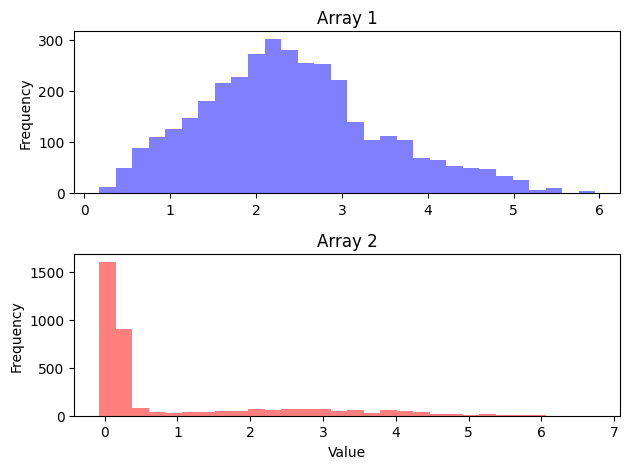

In [31]:
fig, axs = plt.subplots(2)

axs[0].hist(ex_set_sc_genes, bins=30, alpha=0.5, label='Array 1', color='blue')
axs[0].set_title('Array 1')
axs[0].set_ylabel('Frequency')

axs[1].hist(ex_set_preds, bins=30, alpha=0.5, label='Array 2', color='red')
axs[1].set_title('Array 2')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [20]:
import matplotlib.pyplot as plt

In [27]:
loader.test.__len__()

595

In [23]:
{x for x in finite_iterator.test}

set()

In [25]:
import anndata
path = '/Mounts/rbg-storage1/users/johnyang/cellot/datasets/scrna-sciplex3/hvg.h5ad'
data = anndata.read(path)

In [ ]:
data.var

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

2023-06-23 13:58:31,655 Note: detected 80 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2023-06-23 13:58:31,656 Note: NumExpr detected 80 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-06-23 13:58:31,658 NumExpr defaulting to 8 threads.


In [33]:
# Raw counts
expressing_cells = data[:, 'ENSG00000243620.1'].X > 0

# Normalized/log-transformed data, use a suitable threshold
# expressing_cells = data[:, 'ENSG00000243620.1'].X > 0


In [35]:
expression_levels = data[expressing_cells, 'ENSG00000243620.1'].X

In [40]:
# Skip if data is already normalized
adata = sc.pp.normalize_total(data, target_sum=1e6)